# Hello, _nbpresent_!

In [ ]:
import nbpresent
nbpresent.__version__

# Hello, _nbpresent_!

In [ ]:
import nbpresent
nbpresent.__version__

# Supervised Learning Capstone Project

## Exploring Wage Disparities Across Occupations

In this notebook I will be exploring the Kaggle dataset of the US Bureau of Labor Statistics January 2015 report on income by gender and occupation. The dataset states that it shows 535 different occupations, and their corresponding weekly median incomes, broken down into men, women, and all, columns. Also included are reported numbers of emplyees for each occupation. 

### A few things to note before we get started. 

We are going to be using a few different modules for this experiment. We will be measuring how well we are doing using the different models built in scoring mechanism and also accuracy_score, which measures your predicted labels to your correct labels. 

In [412]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, train_test_split
%matplotlib inline

In [413]:
import os
curr_directory = os.getcwd()
datafile = curr_directory + "/inc_occ_gender.csv"


### Bring in the data, take a peek at it

In [414]:
genderwage = pd.read_csv(datafile)
genderwage.head()

,Occupation,All_workers,All_weekly,M_workers,M_weekly,F_workers,F_weekly
0,ALL OCCUPATIONS,109080,809,60746,895,48334,726
1,MANAGEMENT,12480,1351,7332,1486,5147,1139
2,Chief executives,1046,2041,763,2251,283,1836
3,General and operations managers,823,1260,621,1347,202,1002
4,Legislators,8,Na,5,Na,4,Na


Looks like the occupation categories are all upper case. That's going to make it easy for us to pull them out later. Nan values will dropped, and we'll check the dtypes to make sure everything that is a number, is an int or a float.

In [415]:
genderwage.count()

Occupation     558
All_workers    558
All_weekly     558
M_workers      558
M_weekly       558
F_workers      558
F_weekly       558
dtype: int64

In [416]:
genderwage.dtypes

Occupation     object
All_workers     int64
All_weekly     object
M_workers       int64
M_weekly       object
F_workers       int64
F_weekly       object
dtype: object

In [417]:
genderwage[['All_weekly',
            'M_weekly',
            'F_weekly']] = genderwage[['All_weekly',
                                       'M_weekly',
                                       'F_weekly']].apply(pd.to_numeric, errors='coerce')

In [418]:
genderwage.dtypes

Occupation      object
All_workers      int64
All_weekly     float64
M_workers        int64
M_weekly       float64
F_workers        int64
F_weekly       float64
dtype: object

In [419]:
genderwage.isnull().sum()

Occupation       0
All_workers      0
All_weekly     236
M_workers        0
M_weekly       326
F_workers        0
F_weekly       366
dtype: int64

# put words here

# talk about what you are doing next

I found the categories and then made them their own df. Then I used the occupation column to make two more columns, an occupation label column and number column.

In [420]:
categories = [] 
for i in genderwage['Occupation']:
    if i.isupper()==True:
        categories.append(i)

categories_df = genderwage.loc[genderwage['Occupation'].isin(categories)].reset_index(drop=True).copy()


In [421]:
indices =[]
category_index = pd.Index(list(genderwage['Occupation']))
for i in categories:
    index = category_index.get_loc(i)
    indices.append(index)

In [422]:
genderwage.insert(1, 'Occupation_Category', 0)

In [423]:
cat_count = -1
index_copy = pd.Index(list(genderwage['Occupation']))
for x in genderwage['Occupation']:
    current_index = index_copy.get_loc(x)
    genderwage.iloc[current_index, genderwage.columns.get_loc('Occupation_Category')] = cat_count
    if x.isupper():
        cat_count = cat_count + 1
        genderwage.iloc[current_index, genderwage.columns.get_loc('Occupation_Category')] = cat_count
    

In [424]:
genderwage.insert(1, 'Occupation_Category_label', 0)

In [425]:
cat_label = 'nothing'
for x in genderwage['Occupation']:
    current_index = index_copy.get_loc(x)
    genderwage.iloc[current_index, genderwage.columns.get_loc('Occupation_Category_label')] = cat_label
    if x.isupper():
        cat_label = x
        genderwage.iloc[current_index, genderwage.columns.get_loc('Occupation_Category_label')] = cat_label
    

In [426]:
 # getting rid of 'All Occupations' row

# Here i made a dataframe of the occupations that did NOT report anythin for female weekly wages

Not really sure what good this will do, but maybe i could compare the occupational categories that did not report wages vs those that did?

In [427]:
no_wage_df = genderwage.where(genderwage['F_weekly'].isnull())


In [428]:
no_wage_df.isnull().sum()

Occupation                   192
Occupation_Category_label    192
Occupation_Category          192
All_workers                  192
All_weekly                   428
M_workers                    192
M_weekly                     468
F_workers                    192
F_weekly                     558
dtype: int64

In [429]:
no_wage_df = no_wage_df.dropna(axis=0, how='all')
no_wage_df.isnull().sum()

Occupation                     0
Occupation_Category_label      0
Occupation_Category            0
All_workers                    0
All_weekly                   236
M_workers                      0
M_weekly                     276
F_workers                      0
F_weekly                     366
dtype: int64

In [430]:
no_wage_df['GenderRatio'] = no_wage_df['F_workers'] / no_wage_df['M_workers']

In [431]:
no_wage_df.describe()

,Occupation_Category,All_workers,All_weekly,M_workers,M_weekly,F_workers,F_weekly,GenderRatio
count,366.000000,366.000000,130.000000,366.000000,90.000000,366.000000,0.0,359.000000
mean,14.688525,69.699454,953.753846,58.896175,979.266667,10.795082,NaN,inf
std,6.951198,128.537814,355.417258,124.705396,376.822874,12.813908,NaN,NaN
min,1.000000,0.000000,354.000000,0.000000,389.000000,0.000000,NaN,0.000000
25%,9.000000,11.000000,685.500000,7.000000,725.250000,1.000000,NaN,0.030769
50%,18.000000,30.000000,874.500000,20.000000,879.500000,5.000000,NaN,0.200000
75%,21.000000,67.000000,1152.500000,49.000000,1103.250000,17.000000,NaN,0.825758
max,22.000000,1181.000000,1952.000000,1155.000000,1892.000000,49.000000,NaN,inf


# Here is where I make the dataframe that I'm going to be doing my modeling with

In [432]:
cleanedgenderwage = genderwage.dropna(axis=0, how='any').copy()
cleanedgenderwage = cleanedgenderwage.loc[~cleanedgenderwage['Occupation'].isin(categories)].reset_index(drop=True)


In [434]:
cleanedgenderwage['Occupation_Category_label'].value_counts()

OFFICE                     17
MANAGEMENT                 16
BUSINESS                   12
PRODUCTION                 11
SALES                      11
CULINARY                    7
HEALTHCARE PROFESSIONAL     7
COMPUTATIONAL               7
EDUCATION                   4
TRANSPORTATION              4
SOCIAL SERVICE              3
SCIENCE                     3
PROTECTIVE SERVICE          3
SERVICE                     3
GROUNDSKEEPING              3
ARTS                        3
ENGINEERING                 2
AGRICULTURAL                1
LEGAL                       1
HEALTHCARE SUPPORT          1
Name: Occupation_Category_label, dtype: int64

## Those category counts are way too low!

In [487]:
# combine categories 
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'LEGAL', 'Occupation_Category_label'] = 'SOCIAL SERVICE'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'HEALTHCARE SUPPORT', 'Occupation_Category_label'] = 'HEALTHCARE PROFESSIONAL'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'AGRICULTURAL', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'CONSTRUCTION', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'MAINTENANCE', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'

cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'GROUNDSKEEPING', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'ENGINEERING', 'Occupation_Category_label'] = 'SCIENCE'

cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'PROTECTIVE SERVICE', 'Occupation_Category_label'] = 'OTHER'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'SERVICE', 'Occupation_Category_label'] = 'OTHER'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'ARTS', 'Occupation_Category_label'] = 'OTHER'


In [488]:
cleanedgenderwage['Occupation_Category_label'].value_counts()

OFFICE                     17
MANAGEMENT                 16
BUSINESS                   12
SALES                      11
PRODUCTION                 11
OTHER                       9
HEALTHCARE PROFESSIONAL     8
COMPUTATIONAL               7
CULINARY                    7
SCIENCE                     5
INFRASTRUCTURE SUPPORT      4
EDUCATION                   4
SOCIAL SERVICE              4
TRANSPORTATION              4
Name: Occupation_Category_label, dtype: int64

14 categories for occupations is quite enough o.o

## Preliminary Data Exploration

Looking at distribution plots for our current features

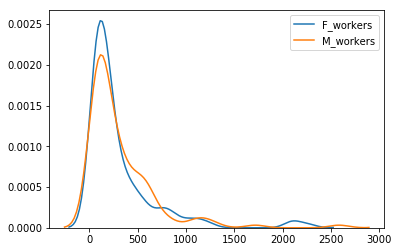

In [437]:
sns.kdeplot(data=cleanedgenderwage['F_workers'])
sns.kdeplot(data=cleanedgenderwage['M_workers'])
plt.show()

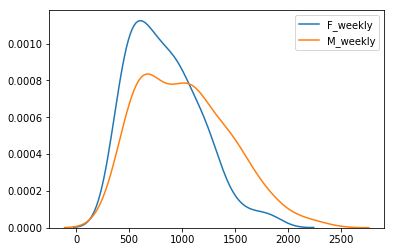

In [438]:
sns.kdeplot(data=cleanedgenderwage['F_weekly'])
sns.kdeplot(data=cleanedgenderwage['M_weekly'])
plt.show()

# Lets look at the womens and mens salaries on a scatter plot

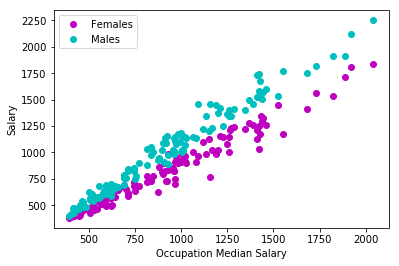

In [439]:
# look at female wages vs male wages on a scatter plot
plt.plot(cleanedgenderwage['All_weekly'], cleanedgenderwage['F_weekly'], 'o', color='m')
plt.plot(cleanedgenderwage['All_weekly'], cleanedgenderwage['M_weekly'], 'o', color='c')
plt.xlabel('Occupation Median Salary')
plt.legend(['Females','Males'])
plt.ylabel('Salary')
plt.show()

# Ook, well thats ugly. 

# Lets look at the income by occupation.

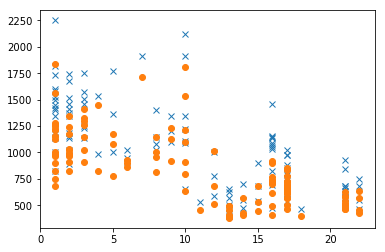

In [440]:
plt.plot(cleanedgenderwage['Occupation_Category'], cleanedgenderwage['M_weekly'], 'x')
plt.plot(cleanedgenderwage['Occupation_Category'], cleanedgenderwage['F_weekly'], 'o')
plt.show()

## Now lets create some features

Woo!

Here what we're doing is comparing the womens income to mens income to get a ratio that shows up what percentage of mens incomes women make.

Then we divided the female workforce by the male workforce to get our gender ratio. 

After that, I noticed there was a incosistency in the counts for men and women workers compared to the 'all workers' column. So I made another column to show which ones were off. Might not need this column.

Then I made two complimentary columns of the mens and womens share of workers by dividing each by all workers.

In [441]:
cleanedgenderwage['WageGap_as_Ratio'] = cleanedgenderwage['F_weekly'] / cleanedgenderwage['M_weekly']
cleanedgenderwage['GenderRatio'] = cleanedgenderwage['F_workers'] / cleanedgenderwage['M_workers']
cleanedgenderwage['All_Workers_Difference'] = cleanedgenderwage['All_workers'] - (cleanedgenderwage['M_workers'] + cleanedgenderwage['F_workers'])
cleanedgenderwage['F_share'] = cleanedgenderwage['F_workers'] / cleanedgenderwage['All_workers']
cleanedgenderwage['M_share'] = cleanedgenderwage['M_workers'] / cleanedgenderwage['All_workers']

## Next I marked which occupations are male dominated. 

Any ratio under .85 is considered male dominated as that shows a 15% or more majority over women.

In [442]:
def male_dom(x):
    if x > .85:
        return 0
    return 1

cleanedgenderwage['Male_Dominated'] = cleanedgenderwage['GenderRatio'].apply(male_dom)

Then i did the same thing to find significan't wage gaps. Anything over 15%.

In [443]:

cleanedgenderwage['Significant_wage_gap'] = np.where(cleanedgenderwage['WageGap_as_Ratio'] > .85, 0, 1)

In [444]:
# same features, just in the categories dataframe
# Dont' know if i need this cell

categories_df[['All_weekly',
            'M_weekly',
            'F_weekly']] = categories_df[['All_weekly',
                                       'M_weekly',
                                       'F_weekly']].apply(pd.to_numeric, errors='coerce')

categories_df['WageRatio'] = categories_df['F_weekly'] / categories_df['M_weekly']
categories_df['GenderRatio'] = categories_df['F_workers'] / categories_df['M_workers']
categories_df['WageGap'] = categories_df['M_weekly'] - categories_df['F_weekly']
categories_df['F_share'] = categories_df['F_workers'] / categories_df['All_workers']
categories_df['M_share'] = categories_df['M_workers'] / categories_df['All_workers']
categories_df['All_Workers_Difference'] = categories_df['All_workers'] - (categories_df['M_workers'] + categories_df['F_workers'])




## Lets plot some of these new features
Looking at bar plots of weekly income by occupation, wage gap by occupation, gender ratio by occupation, wage ratio by occupation, and a scatter plot of mens weekly income and womens weekly income as a function of the reported occupation median income.

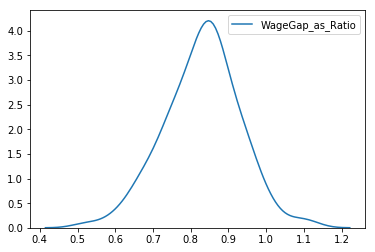

In [445]:
sns.kdeplot(data=cleanedgenderwage['WageGap_as_Ratio'])

# Lets see the gender ratios by occuation 

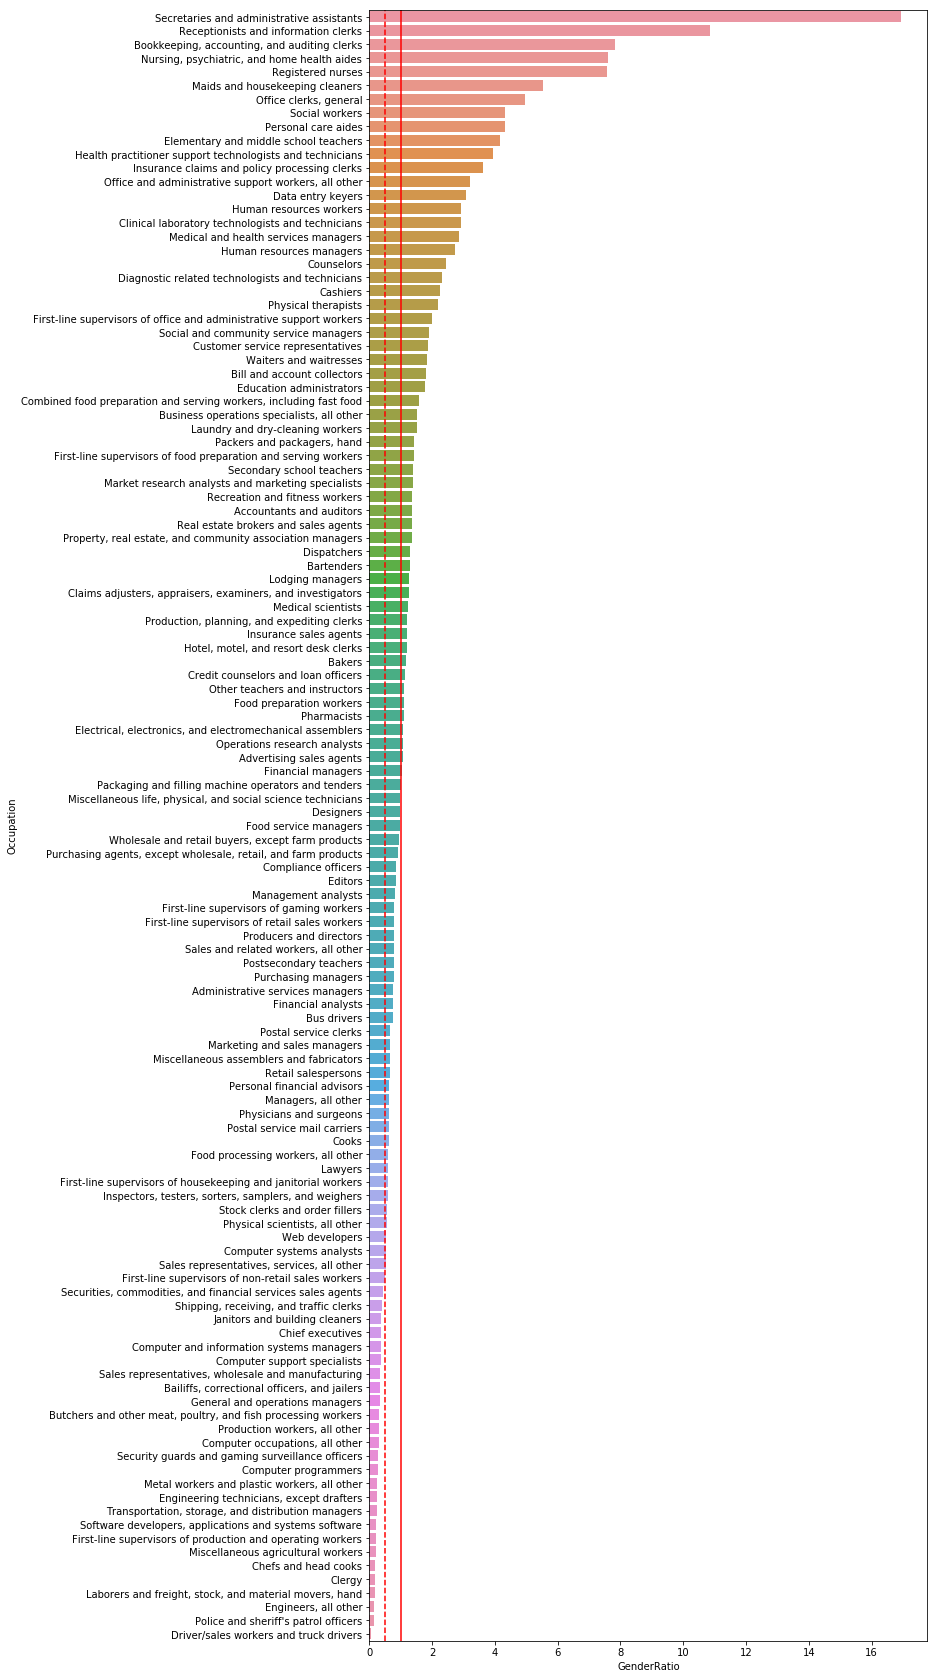

In [446]:

# Now lets look at the ratio of workers
plt.figure(figsize=((10,30)))
sns.barplot(x='GenderRatio',
            y='Occupation',
            data=cleanedgenderwage.sort_values('GenderRatio', ascending=False))
plt.axvline(x=1, color='red', linestyle='solid')
plt.axvline(x=.5, color='red', linestyle='--')
plt.show()

# How about the wage gap by occupation?

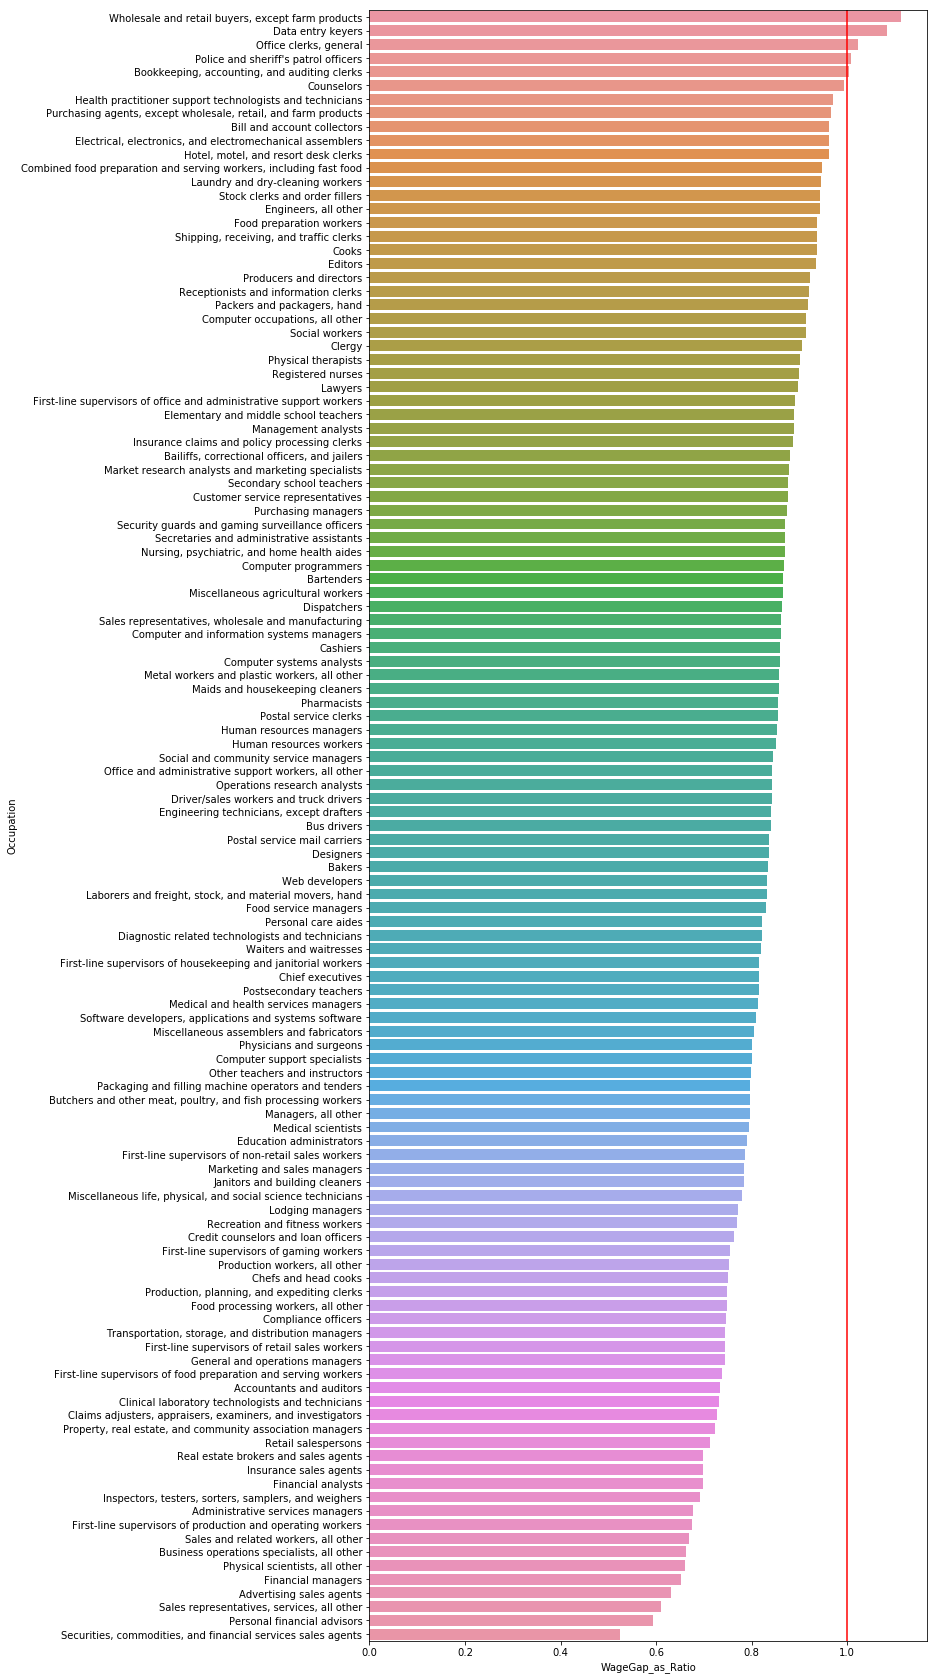

In [447]:
# Look at wage ratio by occupation
plt.figure(figsize=((10,30)))
sns.barplot(x='WageGap_as_Ratio',
            y='Occupation',
            data=cleanedgenderwage.sort_values('WageGap_as_Ratio', ascending=False))
plt.axvline(x=1, color='red', linestyle='solid')
plt.show()

# Lets take a look at some lm plots to see if there is a relationship between income and gender ratios

#  Make these 4 subplots not 4 plots in a row

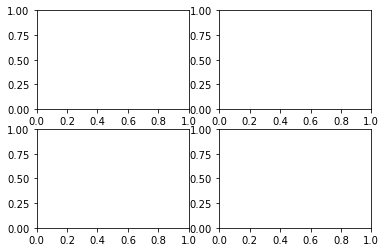

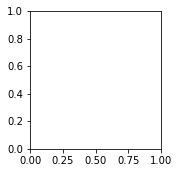

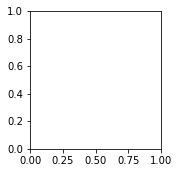

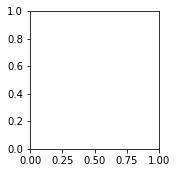

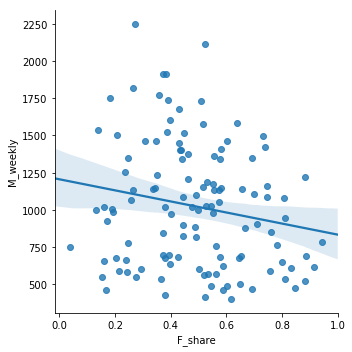

In [471]:
fig, ax = plt.subplots(nrows=2, ncols=2)

plt.subplot(2, 2, 1)
sns.lmplot(x='M_share', y='F_weekly', data=cleanedgenderwage)

plt.subplot(2, 2, 2)
sns.lmplot(x='M_share', y='M_weekly', data=cleanedgenderwage)

plt.subplot(2, 2, 3)
sns.lmplot(x='F_share', y='F_weekly', data=cleanedgenderwage)

plt.subplot(2, 2, 4)
sns.lmplot(x='F_share', y='M_weekly', data=cleanedgenderwage)

plt.show()

# Lets look at a bigger scatter plot of m/f incomes, and color it according to occupation

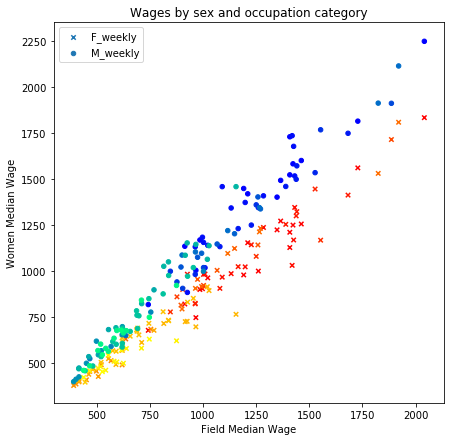

In [502]:
# plot wage by gender and color by occupation category
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_title("Wages by sex and occupation category")
ax.set_xlabel("Field Median Wage")
ax.set_ylabel("Women Median Wage")
x = cleanedgenderwage['All_weekly']
y = cleanedgenderwage['F_weekly']
y2 = cleanedgenderwage['M_weekly']
colors = [str(item) for item in cleanedgenderwage['Occupation_Category']]

ax.scatter(x, y, s=20, c=cleanedgenderwage['Occupation_Category'], marker = 'x', cmap=plt.cm.autumn);
ax.scatter(x, y2 ,s=20, c=cleanedgenderwage['Occupation_Category'], marker = 'o', cmap=plt.cm.winter);
plt.legend()
plt.show()


# Time for some MODELS

we will be reviewing linear or logisitic regression classifier, then lasso regression classifier, then a random forest classifier

The questions I will be looking to answer today is:
     - Can you predict occupational category given wage, gender, gender ratio and share of females for that field? 

If we are able to accurately predict the occuational category using a given wage, gender, or share of females, then perhaps there is more underlying structure influencing wages than skill of employee.

In [473]:
# make new dfs here
F_df = pd.DataFrame()
M_df = pd.DataFrame()

# make category variable for gender
F_df['Wage'] = cleanedgenderwage['F_weekly']
M_df['Wage'] = cleanedgenderwage['M_weekly']

F_df['Male_Dominated'] = cleanedgenderwage['Male_Dominated']
M_df['Male_Dominated'] = cleanedgenderwage['Male_Dominated']

F_df['Significant_wage_gap'] = cleanedgenderwage['Significant_wage_gap']
M_df['Significant_wage_gap'] = cleanedgenderwage['Significant_wage_gap']

F_df['WageGap_as_Ratio'] = cleanedgenderwage['WageGap_as_Ratio']
M_df['WageGap_as_Ratio'] = cleanedgenderwage['WageGap_as_Ratio']

F_df['Gender'] = np.ones(len(cleanedgenderwage))
M_df['Gender'] = np.zeros(len(cleanedgenderwage))

F_df['F_share'] = cleanedgenderwage['F_share']
M_df['F_share'] = cleanedgenderwage['F_share']
F_df['GenderRatio'] = cleanedgenderwage['GenderRatio']
M_df['GenderRatio'] = cleanedgenderwage['GenderRatio']

F_df['Occupation_Category'] = cleanedgenderwage['Occupation_Category_label']
M_df['Occupation_Category'] = cleanedgenderwage['Occupation_Category_label']


F_df['Occupation_Median_wage'] = cleanedgenderwage['All_weekly']
M_df['Occupation_Median_wage'] = cleanedgenderwage['All_weekly']

combined_df = F_df.append(M_df)



# Lets make a function to test our models,

In [454]:
# set up training and testing sets, fit model, score model
# need to split up dataset before oversampling



def model_testing(model, X_test, y_test, X_train, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scored_model_train = model.score(X_train, y_train)
    scored_model_test = model.score(X_test, y_test)
    model_accuracy = accuracy_score(y_test, y_pred)
    print("Model Score with Training data:")
    print(scored_model_train)
    print("Model Score with Testing data:")
    print(scored_model_test)
    print("Accuracy Score")
    print(model_accuracy)
   

In [455]:
def sampled_set(data, sample_count):
    sampled = np.random.choice(a=data, size=sample_count)
    return(sampled)


In [476]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k=3, ratio=1, kind='regular')

Next steps are to scale our data, split it up and resample our training data, then test our models.

In [490]:
# scale columns here
scaler = StandardScaler()
columns = ['Wage',
           'Male_Dominated',
           'Significant_wage_gap',
           'WageGap_as_Ratio',
           'Gender',
           'F_share', 
           'GenderRatio', 
           'Occupation_Median_wage']
# split up data first, then resample only the training data, maybe try smote again

X = combined_df[columns]

X_std = StandardScaler().fit_transform(X)
y = combined_df['Occupation_Category']

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=.35)


#X_resam, y_resam = smote.fit_sample(X_train, y_train)
# can't SMOTE because we have more neighbors than samples

In [459]:
# set up x and y variables
#X = combined_df.drop(['Occupation_Category'], axis=1)
#y = combined_df['Occupation_Category']

In [491]:
# Linear/logisitic Regression here
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
model_testing(logr, X_test, y_test, X_train, y_train)

Model Score with Training data:
0.461038961038961
Model Score with Testing data:
0.3333333333333333
Accuracy Score
0.3333333333333333


In [461]:
# Lasso Regression classifier here
lasso = linear_model.Lasso()
#model_testing(lasso, X_std, y, .35)

In [492]:
# Ridge Regression classifier here
ridge = linear_model.RidgeClassifier()
model_testing(ridge, X_test, y_test, X_train, y_train)

Model Score with Training data:
0.4090909090909091
Model Score with Testing data:
0.3333333333333333
Accuracy Score
0.3333333333333333


In [493]:
# Random Forest Classifier here
forest = ensemble.RandomForestClassifier(n_estimators=300, max_depth=3)
model_testing(forest, X_test, y_test, X_train, y_train)

Model Score with Training data:
0.5714285714285714
Model Score with Testing data:
0.35714285714285715
Accuracy Score
0.35714285714285715


In [494]:
# SVM?
from sklearn.svm import SVC
svc = SVC()
model_testing(svc, X_test, y_test, X_train, y_train)

Model Score with Training data:
0.44155844155844154
Model Score with Testing data:
0.2619047619047619
Accuracy Score
0.2619047619047619


In [496]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
model_testing(dtree, X_test, y_test, X_train, y_train)

Model Score with Training data:
1.0
Model Score with Testing data:
0.6309523809523809
Accuracy Score
0.6309523809523809


In [495]:
extree = ensemble.ExtraTreesClassifier()
model_testing(extree, X_test, y_test, X_train, y_train)

Model Score with Training data:
1.0
Model Score with Testing data:
0.5238095238095238
Accuracy Score
0.5238095238095238


In [497]:
gradient = ensemble.GradientBoostingClassifier()
model_testing(gradient, X_test, y_test, X_train, y_train)

Model Score with Training data:
1.0
Model Score with Testing data:
0.6428571428571429
Accuracy Score
0.6428571428571429


The tpp three preliminary models were the decision tree classifier, the extra trees classifier and the gradient boosting classifier. 

Next we will use SKLearn's built in tool GrilSearch to find the best hyperparameters.

In [498]:
# Put hyper parameter adjustment here
from sklearn.model_selection import GridSearchCV

extra_tree_param = {'criterion': ('gini', 'entropy'),
                    'max_depth': (2, 3, 5),
                    'n_estimators': (10, 50, 100)}
decision_tree_param = {'criterion': ('gini', 'entropy'),
                       'max_depth': (2, 3, 5)}
gradient_params = {'learning_rate': (.01, .5, 1),
                   'n_estimators':(100, 150, 200),
                   'max_depth':(2, 3, 4, 5, 6)}

def check_grid(estimator, params):
    grid_classifier = GridSearchCV(estimator=estimator, param_grid=params)
    grid_classifier.fit(X_std, y)
    grid_score = grid_classifier.score(X_std, y)
    print(grid_score)

In [499]:
check_grid(dtree, decision_tree_param)

0.6638655462184874


In [500]:
check_grid(extree, extra_tree_param)

0.7521008403361344


In [501]:
check_grid(gradient, gradient_params)

1.0


In [ ]:
# get params here for best model

In [ ]:
X_std.shape

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k=3, ratio=1, kind='borderline1')

In [ ]:
y_values = y.values
y_values.shape

In [ ]:
# Put model validation here

# Put conclusion here